In [87]:
import numpy as np
import pandas as pd
import glob
import os
from scipy.special import erf as erf # Import error function
from scipy.special import erfc as erfc # Import error function
from scipy.special import erfcinv as erfcinv # Import error inverse function
from scipy.stats import linregress
import matplotlib.pyplot as plt
import re

# Code to process the simulation log folder
The following codes are used to process simulation logs, finally generate a CSV file in which all the parameters (i.e. slop and intercept) obtained from single variable linear regression are saved.

## A short intro for the simulation result log layout
Les numéros 22 à 41 correspondent à MRC limité en slotted Aloha, 42 à 61 à MRC limité en pure Aloha avg Inteférence, 62 à 81 à MRC limité en pure Aloha max Int.

Chaque ligne correspond à un nombre de branches. Par exemple 47 correspond à MRC où on somme les 47-42+1=6 meilleurs SIR en pure Aloha avg Interf. 

Tu remarques que les cas 22, 42 et  62 correspondent en fait au SC (on ne prend que le meilleur SIR, si cela marche, c'est bon ; en revanche si le meilleur est inférieur au seuil, tous les autres sont également plus petits).

We are interested in rows:
- with index 23, 47 (slotted Aloha)
- with index 43, 47 (pure Aloha with mean interference)
- with idnex 63, 67 (pure Aloha with max interference)

As a comparison reference, we are also interested in rows:
- with index 13: slotte avec shadow et macrodiv MRC,  ex nbPcktMrcOK
- with index 14: Pur interf moyenne avec shadow et macrodiv MRC, ex nbPcktMrcOKPureAvg
- with index 15: Pur interf max avec shadow et macrodiv MRC, ex nbPcktMrcOKPureMax

In [88]:
def sim_log_dir_parser(sim_log_dir, nb_nst_bs_options):
    '''
        This utility take a simulation logs as input parameters. Read each simulation log inside.
        Do the single variable linear regression for all cases (slotted Aloha, pure Aloha with mean interference,
        pure Aloha with max interference.)
        Store the obtained slop and intercept into a new dataframe, then output this dataframe as a new CSV file.
        
        @para: nb_nst_bs_options: a list such as [23,43,63], each element refers to the index of input csv file.
        for example, row with index 43 refers to the simulation results taking into account the 2 best surrounding
        BS
    '''
    # Itrate each simulation log in the given path
    # Each log file starts with 'Aloha' and ends with '.csv'.
    
    # credit: https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe
    result_lst = []
    
    for sim_log in glob.iglob(os.path.join(sim_log_dir, 'Aloha*.csv')):
        result_item = sim_log_parser(sim_log, nb_nst_bs_options)
        result_lst.append(result_item)
        # option index=[0] is a must. otherwise error message: If using all scalar values, you must pass an index
    rlt_df = pd.DataFrame(result_lst)
#     print("DEBUG: show the content of targe list:")
#     print(rlt_df)

    # Adjust the column order
    columns=[
        'gamma',
        'K_slot','B_slot','slot_MAPE',
        'K_pure_mean','B_pure_mean','pure_mean_MAPE',
        'K_pure_max','B_pure_max','pure_max_MAPE'
    ]
    rlt_df = rlt_df[columns].sort_values(by=['gamma'])
    print('********************************************')
    print(rlt_df)
    rlt_df.info()
    print('********************************************')
    print('Output all parameters obtained from curve fitting into a CSV file...')
    rlt_df.to_csv("result.csv", index=False)

def sim_log_parser(sim_log, nb_nst_bs_options):
    '''
        This utility takes the path of simulation log file as input.
        Returns linear regression parameters.
        
        Note: all simulation settings are clarified in the log file name. For example: "AlohaMultg40s8t3b20.csv"
        g40 => gamma = 4.0
        s8  => shadowing effect = 8 dB (we don't use this parameters)
        t3  => capture ratio, theta_dB = 3.0
        b20 => I remember this is related to BS spatial density??
        
        @para: nb_nst_bs_options: according to different combination of (n nearest BS, Aloha type)
        Take the row with index 43 from Dataframe
    '''
    pattern = re.compile(r"AlohaMultg(\d+)s(\d+)t(\d+)")
    simu_setting = re.findall(pattern, sim_log)[0]
        
    gamma = float(simu_setting[0])/10.0
    # sigma_dB = float(simu_setting[1])
    theta_dB = float(simu_setting[2])
    theta = np.power(10.0, theta_dB/10)
    # First 9 rows in the log file are ignored
    # Then take the following 81 lines (without consideration of header line)
    plr_df = pd.read_csv(sim_log, sep=";", decimal=',', index_col=0, skiprows=9, nrows=81).dropna(axis=1, how='all')
    # Remember to convert the header line from string to float. At the same time, comma should be changed to point
    plr_df.columns = [float(x.replace(',', '.')) for x in plr_df.columns.values]
    
    
#     print(plr_df)
    
    # Choose those columns that value is greater than a plr_min, e.g, 0.001
    PLR_MIN = 0.001
#   nb_nst_bs_options = [23, 27, 43, 47, 63, 67]
#   nb_nst_bs_options = [23, 43, 63]
    
    table_item ={'gamma':gamma}
    
    for nb_nst_bs in nb_nst_bs_options:
        
        plr_series = plr_df.loc[nb_nst_bs]

        plr_series = plr_series[plr_series > PLR_MIN]

        slop, intercept, MAPE = curve_fitting(plr_series, gamma, theta)
        print("nb_nst_bs", nb_nst_bs, "Gamma:", gamma, theta_dB, slop, intercept, "MAPE:", MAPE*100)
        
        
        # should note that: 13,14,15 are the ideal case of MRC...

        if nb_nst_bs == 13 or (nb_nst_bs > 20 and nb_nst_bs < 40): 
            table_item['K_slot'] = slop
            table_item['B_slot'] = intercept
            table_item['slot_MAPE'] = MAPE*100
        
        elif nb_nst_bs == 14 or (nb_nst_bs > 40 and nb_nst_bs < 60): 
            table_item['K_pure_mean'] = slop
            table_item['B_pure_mean'] = intercept
            table_item['pure_mean_MAPE'] = MAPE*100
        
        elif nb_nst_bs == 15 or (nb_nst_bs > 60 and nb_nst_bs < 80):
            table_item['K_pure_max'] = slop
            table_item['B_pure_max'] = intercept
            table_item['pure_max_MAPE'] = MAPE*100
        else:
            exit("Please carefully check your target index...")
        
    return table_item
    
def curve_fitting(entry, gamma, theta):
    '''
        Take a pandas Series, along side with simulation setting parameters such as gamma and theta, as input
        The input Series is a one row in file such as: 
        /Users/qsong/Documents/slotted_aloha_related_project/logs/SimuApril23/AlohaMultg40s8t3b20.csv
    '''
    # A signle variable linear regression
    loads = pd.Series(entry.index.values)
    X_ref = loads*np.power(theta, 2.0/gamma)
    Y_ref = np.power(erfcinv(entry), -1.0)

    reg_results = linregress(X_ref, Y_ref)
    slop = reg_results[0]
    intercept = reg_results[1]
    
    # loads_x is used to plot the line generated by the following function....
    loads_x = np.linspace(0.8*np.min(loads), np.max(loads)*1.1, num=100)
    
    predicted_results = 1.0 - erf(1.0/(slop*X_ref + intercept))
    # https://www.dataquest.io/blog/understanding-regression-error-metrics/
    MAPE = np.mean(abs(predicted_results.values-entry.values)/entry.values)
    
    fig, axes = plt.subplots(1,2)
    axes[0].plot(X_ref, Y_ref, 'ro')
    axes[0].plot(X_ref, slop*X_ref+intercept, 'b')
    axes[0].set_ylabel('Y_ref')
    axes[0].grid()

    axes[1].set_yscale("log")
    axes[1].plot(loads, entry, 'ro')
    axes[1].plot(loads_x, target_func(loads_x, theta, gamma, slop, intercept), 'b')
    axes[1].set_ylabel('packet loss rate')
    axes[1].axis([0, 0.6, 0.001, 1])
    axes[1].grid()
    axes[1].set_title("case:{0}".format(gamma))
    
    return slop, intercept, MAPE

def target_func(loads_x, theta, gamma, slop, intercept):
    '''
        According to our analysis, the packet loss rate function with respect to normalized load
        is as follows:
    '''
    x = loads_x*np.power(theta, 2.0/gamma)
    return 1.0 - erf(1.0/(slop*x + intercept))

nb_nst_bs 27 Gamma: 4.5 3.0 1.5878612922361826 0.25010445584841245 MAPE: 8.876315602749955
nb_nst_bs 47 Gamma: 4.5 3.0 2.2021194440135825 0.23635969058537576 MAPE: 6.23796751474568
nb_nst_bs 67 Gamma: 4.5 3.0 2.919261281405361 0.24906012346900275 MAPE: 5.46265448769019
nb_nst_bs 27 Gamma: 3.3 3.0 1.8884999087383112 0.16251162032416033 MAPE: 4.079998245317043
nb_nst_bs 47 Gamma: 3.3 3.0 2.375647975061276 0.15174488040280176 MAPE: 5.617118107517509
nb_nst_bs 67 Gamma: 3.3 3.0 3.3475486642868697 0.13579189695997895 MAPE: 5.822873805552096
nb_nst_bs 27 Gamma: 4.0 3.0 1.6878577097052296 0.2171246166653681 MAPE: 7.471784821902344
nb_nst_bs 47 Gamma: 4.0 3.0 2.265218217667265 0.20181741450486534 MAPE: 6.046530371907119
nb_nst_bs 67 Gamma: 4.0 3.0 3.0493172558709123 0.21100764657662652 MAPE: 3.375277315307801
nb_nst_bs 27 Gamma: 3.0 3.0 2.072742216405514 0.11740935533598318 MAPE: 5.427628149902287
nb_nst_bs 47 Gamma: 3.0 3.0 2.5746642964728346 0.09645112216110352 MAPE: 11.988865040207418
nb_ns

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


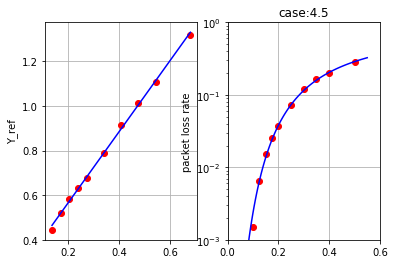

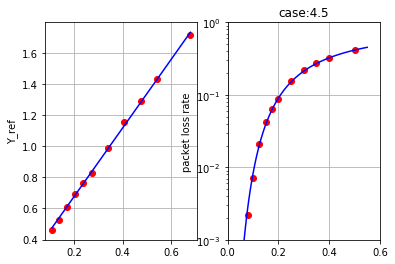

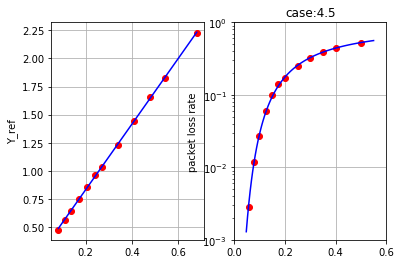

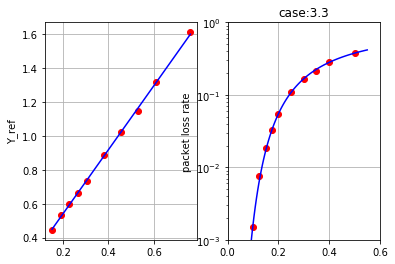

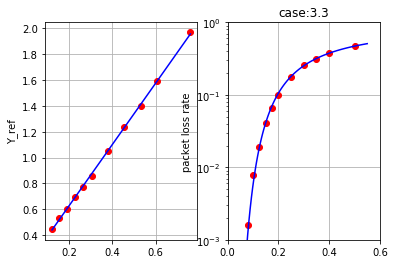

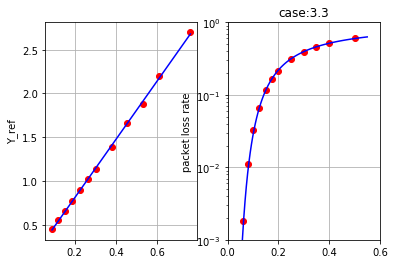

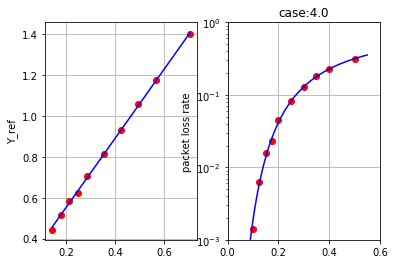

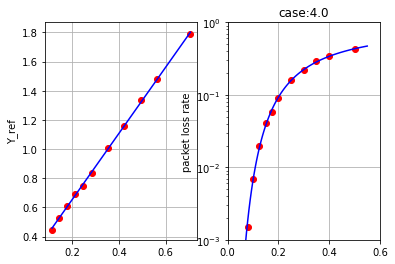

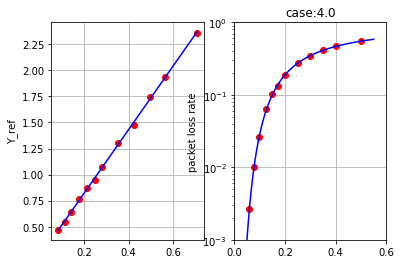

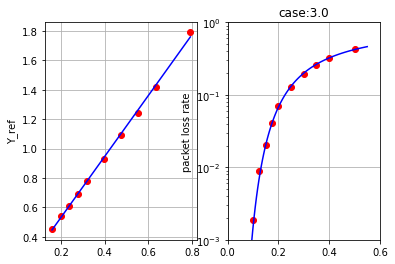

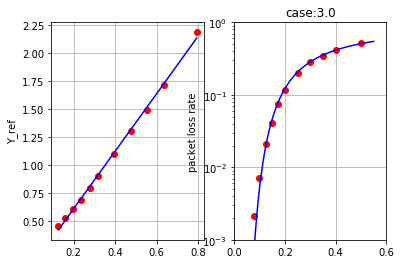

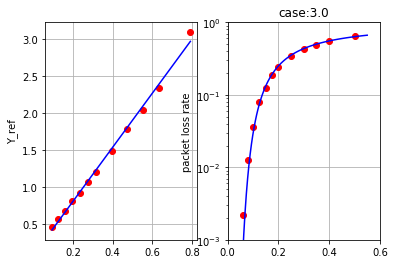

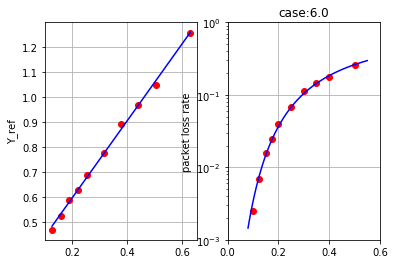

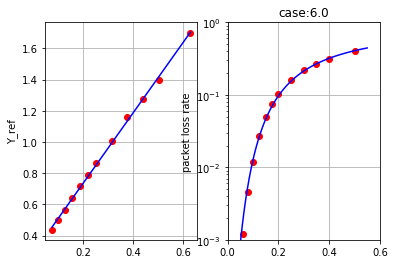

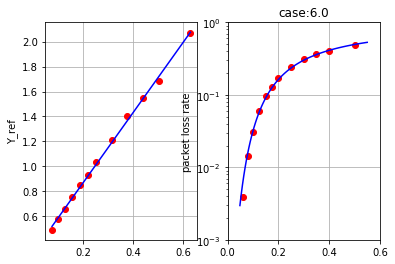

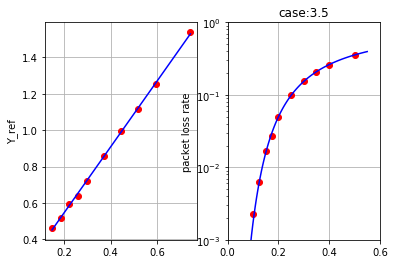

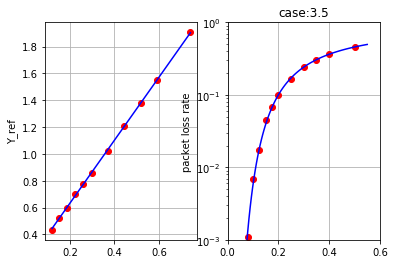

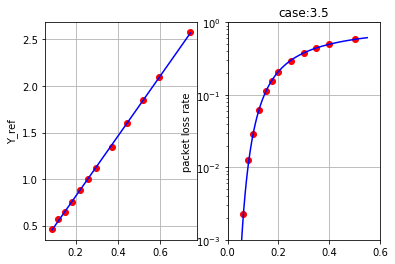

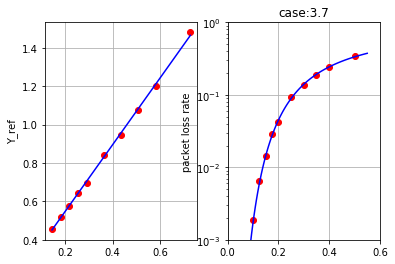

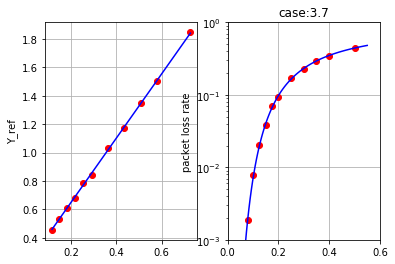

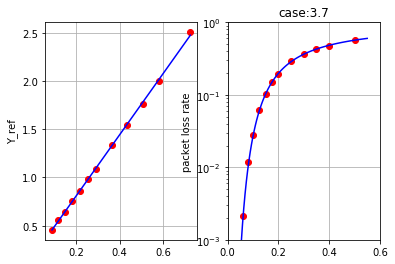

In [89]:
SIM_LOG_DIR = '/Users/qsong/Documents/slotted_aloha_related_project/logs/Simulation5mars2019'
# SIM_LOG_DIR = '/Users/qsong/Documents/slotted_aloha_related_project/logs/SimuApril23'
SIM_LOG_DIR = "/Users/qsong/Documents/slotted_aloha_related_project/logs/Simu13mar2019AlohaMulticell1000BS"

# [13,14,15] => Ideal MRC. Namely with infinite number of involved BS.
sim_log_dir_parser(SIM_LOG_DIR, nb_nst_bs_options = [27, 47, 67])

# sim_log_dir_parser(SIM_LOG_DIR, nb_nst_bs_options = [13,14,15])

# Plot the curve fitting figure for each $\gamma$, for each Aloha type

In this section, we would like to create a plot grid of 7X3. Each row represents for a $\gamma$ and each column represents an Aloha type.

To do this, we rely on two previously obtained CSV files: ***all_curve_fitting_results_2best_bs.csv*** and ***all_curve_fitting_results_6best_bs.csv***

We will take the case where 6 best sourrouding BS as example.

In [95]:
RLT_2BST_BS = "all_curve_fitting_results_2best_bs.csv"
RLT_6BST_BS = "all_curve_fitting_results_6best_bs_new.csv"
RLT_ALL_BST_BS ="all_curve_fitting_results_all_best_bs.csv"
# we just want to plot the case for gamma = 3.3, 3.5, 4.0, 4.5
INTERST_GAMMAS = [3.3, 4.0, 4.5]
# The following index refer to the simulation results of 
# INDEX_LST = [27, 47, 67]

TARGET_CASE = '2'
INDEX_LST = None
TARGET_CSV = None
PLR_MIN = 0.001
theta_dB = 3.0 #unit dB
theta = np.power(10, theta_dB/10.0)

if TARGET_CASE == 'Ideal':
    INDEX_LST = [13, 14, 15]
    TARGET_CSV = RLT_ALL_BST_BS
elif TARGET_CASE == '6':
    INDEX_LST = [27, 47, 67]
    TARGET_CSV = RLT_6BST_BS
elif TARGET_CASE == '2':
    INDEX_LST = [23, 43, 63]
    TARGET_CSV = RLT_2BST_BS
else:
    print("You have to select one case from 'Ideal', '2', '6'!")
    

In [96]:
df = pd.read_csv(TARGET_CSV)
# df.info()
# df = df.loc[df['gamma'].isin(INTERST_GAMMAS)]

# We only take into account the case where gamma <=4.5
df = df[df['gamma']<=4.5]
df.info()
df.head(6)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data columns (total 10 columns):
gamma             6 non-null float64
K_slot            6 non-null float64
B_slot            6 non-null float64
slot_MAPE         6 non-null float64
K_pure_mean       6 non-null float64
B_pure_mean       6 non-null float64
pure_mean_MAPE    6 non-null float64
K_pure_max        6 non-null float64
B_pure_max        6 non-null float64
pure_max_MAPE     6 non-null float64
dtypes: float64(10)
memory usage: 528.0 bytes


,gamma,K_slot,B_slot,slot_MAPE,K_pure_mean,B_pure_mean,pure_mean_MAPE,K_pure_max,B_pure_max,pure_max_MAPE
0,3.0,2.369210,0.208595,2.230116,2.895524,0.204466,3.146951,3.910653,0.221638,1.600250
1,3.3,2.125148,0.250252,7.515280,2.651382,0.249477,8.920000,3.657347,0.249016,4.663669
2,3.5,1.971010,0.270894,8.973300,2.529162,0.257819,8.977962,3.406034,0.279663,4.328934
3,3.7,1.901076,0.282813,5.849764,2.443956,0.282216,5.067713,3.276458,0.303065,4.000044
4,4.0,1.822969,0.294570,10.694210,2.424173,0.283602,9.387246,3.195924,0.314186,3.510204
5,4.5,1.689474,0.314385,6.860833,2.279296,0.310942,5.520880,2.984484,0.339125,3.217733


Deal with gamma: 3.3
df_tmp:
   gamma    K_slot    B_slot  slot_MAPE  K_pure_mean  B_pure_mean  \
1    3.3  2.125148  0.250252    7.51528     2.651382     0.249477   

   pure_mean_MAPE  K_pure_max  B_pure_max  pure_max_MAPE  
1            8.92    3.657347    0.249016       4.663669  
[2.12514842]
/Users/qsong/Documents/slotted_aloha_related_project/logs/Simu13mar2019AlohaMulticell1000BS/AlohaMultg33s8t3b20.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 1 to 81
Data columns (total 12 columns):
0.06     81 non-null float64
0.08     81 non-null float64
0.1      81 non-null float64
0.125    81 non-null float64
0.15     81 non-null float64
0.175    81 non-null float64
0.2      81 non-null float64
0.25     81 non-null float64
0.3      81 non-null float64
0.35     81 non-null float64
0.4      81 non-null float64
0.5      81 non-null float64
dtypes: float64(12)
memory usage: 8.2 KB
Deal with gamma: 4.0
df_tmp:
   gamma    K_slot   B_slot  slot_MAPE  K_pure_mean  B_pure_mean

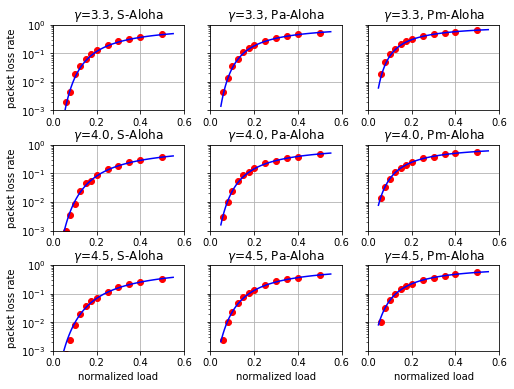

In [114]:
# credit: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
# How to iterate a DataFrame
fig, axes = plt.subplots(len(INTERST_GAMMAS),3, sharey='row')

for j, itst_gamma in enumerate(INTERST_GAMMAS):
    print("Deal with gamma:", itst_gamma)
    df_tmp = df.loc[df['gamma']==itst_gamma]
    print("df_tmp:")
    print(df_tmp)
    print(df_tmp.get(['K_slot']).values[0])
    # the file name prefix for the interested file
    sim_log = os.path.join(SIM_LOG_DIR,"AlohaMultg" + str(int(itst_gamma*10))+'s8t3b20.csv')
    print(sim_log)
    df_log = pd.read_csv(sim_log, sep=";", decimal=',', index_col=0, skiprows=9, nrows=81).dropna(axis=1, how='all')
    df_log.columns = [float(x.replace(',', '.')) for x in df_log.columns.values]
    df_log.info()
    
    K_lst = [df_tmp.get(['K_slot']).values[0], df_tmp.get(['K_pure_mean']).values[0], df_tmp.get(['K_pure_max']).values[0]]
    B_lst = [df_tmp.get(['B_slot']).values[0], df_tmp.get(['B_pure_mean']).values[0], df_tmp.get(['B_pure_max']).values[0]]
    
    print('==========')
    for i, nb_nst_bs in enumerate(INDEX_LST):
        
        df_log_series = df_log.loc[nb_nst_bs]

#         df_log_series = df_log[df_log_series > PLR_MIN]
        
        loads = df_log_series.index.values
                
        loads_x = np.linspace(0.8*np.min(loads), np.max(loads)*1.1, num=100)
        X_ref = loads_x*np.power(theta, 2.0/itst_gamma)
        predicted_y = 1.0 - erf(1.0/(K_lst[i]*X_ref + B_lst[i]))
        
        axes[j][i].set_yscale("log")
        axes[j][i].plot(loads, df_log_series, 'ro')
        axes[j][i].plot(loads_x, predicted_y, 'b')
        axes[j][i].set_yticks((0.001,0.01,0.1,1))
        axes[j][i].set_xticks((0,0.2,0.4,0.6))

        axes[j][i].axis([0, 0.6, 0.001, 1])
        axes[j][i].grid()
#         axes[j][i].set_xlabel('normalized load')

        if i == 0:
            axes[j][i].set_title(r"$\gamma$={0}, S-Aloha".format(itst_gamma))
        elif i== 1:
            axes[j][i].set_title(r"$\gamma$={0}, Pa-Aloha".format(itst_gamma))
        elif i== 2:
            axes[j][i].set_title(r"$\gamma$={0}, Pm-Aloha".format(itst_gamma))

        

for j in range(3):
    axes[j][0].set_ylabel('packet loss rate')
    
    axes[2][j].set_xlabel('normalized load')
    
# fig.tight_layout()
fig.set_size_inches(8, 6)
plt.subplots_adjust(hspace=0.4)

plt.savefig('sim_predict_comp_result.pdf', format='pdf', dpi=300)



# create a plot grid of len(INTERST_GAMMAS) X 3
# fig, axes = plt.subplots(len(INTERST_GAMMAS),3)
# axes[0].plot(X_ref, Y_ref, 'ro')
# axes[0].plot(X_ref, slop*X_ref+intercept, 'b')
# axes[0].set_ylabel('Y_ref')
# axes[0].grid()

# axes[1].set_yscale("log")
# axes[1].plot(loads, entry, 'ro')
# axes[1].plot(loads_x, target_func(loads_x, theta, gamma, slop, intercept), 'b')
# axes[1].set_ylabel('packet loss rate')
# axes[1].axis([0, 0.6, 0.001, 1])
# axes[1].grid()
# axes[1].set_title("case:{0}".format(gamma))

# curve fitting to find the relationship $K(\gamma)$ and $B(\gamma)$

For each $\gamma$ we find the parameters K and B in single variable linear model. Obviously, $K$ and $B$ are both function of $\gamma$.

Text(257.079,0.5,'parameter K')

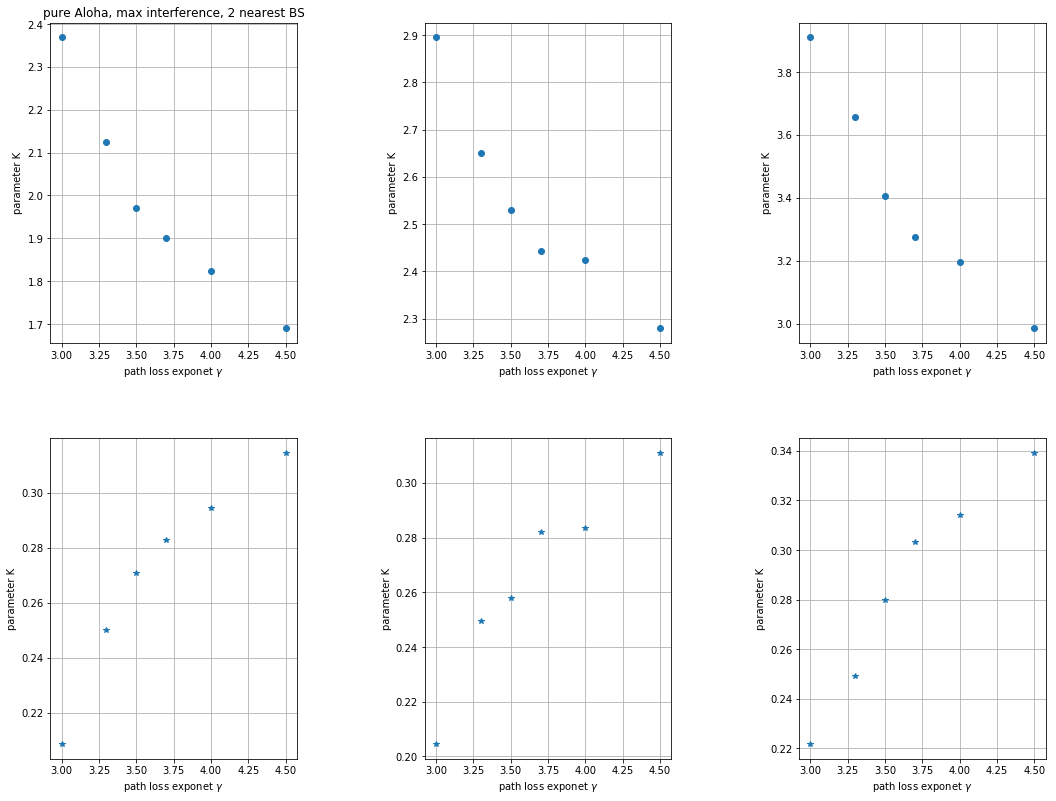

In [80]:
fig2, axes2 = plt.subplots(2,3)
fig2.tight_layout()
fig2.set_size_inches(16, 12)
axes2[0,0].plot(df['gamma'],df['K_slot'], 'o')
axes2[0,0].grid()
axes2[0,0].set_xlabel(r'path loss exponet $\gamma$')
axes2[0,0].set_ylabel(r'parameter K')
axes2[0,0].set_title('pure Aloha, max interference, 2 nearest BS')

# axes2[0,0].axis([3.0, 6.0, 1.5, 2.002])


axes2[0,1].plot(df['gamma'],df['K_pure_mean'], 'o')
axes2[0,1].grid()
axes2[0,1].set_xlabel(r'path loss exponet $\gamma$')
axes2[0,1].set_ylabel(r'parameter K')
# axes2[0,1].axis([3.0, 6.0, 2.3, 2.6])


axes2[0,2].plot(df['gamma'],df['K_pure_max'], 'o')
axes2[0,2].grid()
axes2[0,2].set_xlabel(r'path loss exponet $\gamma$')
axes2[0,2].set_ylabel(r'parameter K')


axes2[1,0].plot(df['gamma'],df['B_slot'], '*')
axes2[1,0].grid()
axes2[1,0].set_xlabel(r'path loss exponet $\gamma$')
axes2[1,0].set_ylabel(r'parameter K')

axes2[1,1].plot(df['gamma'],df['B_pure_mean'], '*')
axes2[1,1].grid()
axes2[1,1].set_xlabel(r'path loss exponet $\gamma$')
axes2[1,1].set_ylabel(r'parameter K')

axes2[1,2].plot(df['gamma'],df['B_pure_max'], '*')
axes2[1,2].grid()
axes2[1,2].set_xlabel(r'path loss exponet $\gamma$')
axes2[1,2].set_ylabel(r'parameter K')


Now we would like to apply curve fitting to find the relationship between parameter $K$ and $B$ with respect to $\gamma$. According to the above figure, their relationship is not lenear. We have to use polynomial curve fitting.

We will use the same fig, generated in previous cell.

In [81]:
k_poly_coeffs0 = np.polyfit(df['gamma'], df['K_slot'], 3)
k_poly_coeffs1 = np.polyfit(df['gamma'], df['K_pure_mean'], 3)
k_poly_coeffs2 = np.polyfit(df['gamma'], df['K_pure_max'], 3)

b_poly_coeffs0 = np.polyfit(df['gamma'], df['B_slot'], 3)
b_poly_coeffs1 = np.polyfit(df['gamma'], df['B_pure_mean'], 3)
b_poly_coeffs2 = np.polyfit(df['gamma'], df['B_pure_max'], 3)

print(k_poly_coeffs0)
print(k_poly_coeffs1)
print(k_poly_coeffs2)

print(b_poly_coeffs0)
print(b_poly_coeffs1)
print(b_poly_coeffs2)

[ -0.22573317   2.79885029 -11.79649328  18.66805069]
[ -0.33940669   4.06054383 -16.35725159  24.5915537 ]
[-0.15011284  1.99953985 -9.20306225 17.59161659]
[ 0.04097192 -0.5031903   2.09303106 -2.64829232]
[ 0.05525186 -0.65695569  2.63594028 -3.28252793]
[-0.00900577  0.06287934 -0.0074772  -0.08063913]


In [82]:
def f0(x):
    return -0.07057104*np.power(x,3)+ 1.06727684*x**2 -5.42887103*x + 10.95030243

def f1(x):
    return -0.06133605*np.power(x,3) + 0.95733968*x**2 - 4.94564688*x + 10.7603481

def f2(x):
    return -0.06734924*np.power(x,3) + 1.07591717*x**2 -5.80656738*x + 13.4749634

def g0(x):
    return 0.01202292*np.power(x,3) -0.18012613*x**2 +  0.90500721*x -1.20837195

def g1(x):
    return 0.00883498*np.power(x,3) -0.13895407*x**2 +  0.73106086*x  -0.9737572 

def g2(x):
    return 0.00612045*np.power(x,3) -0.10592587*x**2 + 0.61328063*x -0.83301615

def curve_fitted_function(thetha_dB, load, gamma, pure, itf_mean):
    '''
        fitted function from simulations...
        :param thetha_dB:
        :param load:
        :param gamma:
        :param pure:
        :param itf_mean:
        :return:
        This function use simulation results to fit the relationship between load and packet loss rate.
        The hard coded parameters are obtained from script mrc_curve_fitting_plot.py. Should consider to modify
    '''
    thetha = np.power(10.0, thetha_dB/10.0)

    if pure == False:
        # slotted case
        K = -0.07057104*np.power(gamma, 3) + 1.06727684*np.power(gamma, 2) -5.42887103*np.power(gamma, 1) + 10.95030243
        B = 0.01202292*np.power(gamma, 3) -0.18012613 * np.power(gamma, 2) + 0.90500721*np.power(gamma, 1) -1.20837195

    else:
        if itf_mean == True:
            K = -0.06133605*np.power(gamma, 3) + 0.95733968*np.power(gamma, 2)  - 4.94564688*np.power(gamma, 1) + 10.7603481
            B = 0.00883498*np.power(gamma, 3) -0.13895407 * np.power(gamma, 2) + 0.73106086*np.power(gamma, 1) - 0.9737572 

        else:
            K = -0.06734924*np.power(gamma, 3) + 1.07591717*np.power(gamma, 2) -5.80656738 *np.power(gamma, 1) + 13.4749634
            B = 0.00612045*np.power(gamma, 3)  -0.10592587 * np.power(gamma, 2) + 0.61328063*np.power(gamma, 1) -0.83301615

    # print "curve fitting fucntion parameter:", K, B
    result =list(1 - erf(np.power(K*load*thetha**(2.0/gamma)+B, -1.0)))


    result = [0 if element > 1 else element for element in result]
    return np.array(result)

def inverse_curve_fitted_function(thetha_dB, pkt_loss, gamma, pure, itf_mean):
    '''
        fitted function from simulations...
        :param thetha_dB:
        :param load:
        :param gamma:
        :param pure:
        :param itf_mean:
        :return:
        This function use simulation results to fit the relationship between load and packet loss rate.
        The hard coded parameters are obtained from script mrc_curve_fitting_plot.py. Should consider to modify
    '''
    from scipy.special import erfcinv as erfcinv # Import error inverse function
    thetha = np.power(10.0, thetha_dB/10.0)

    if pure == False:
        # slotted case
        K = -0.07057104*np.power(gamma, 3) + 1.06727684*np.power(gamma, 2) -5.42887103*np.power(gamma, 1) + 10.95030243
        B = 0.01202292*np.power(gamma, 3) -0.18012613 * np.power(gamma, 2) + 0.90500721*np.power(gamma, 1) -1.20837195

    else:
        if itf_mean == True:
            K = -0.06133605*np.power(gamma, 3) + 0.95733968*np.power(gamma, 2)  - 4.94564688*np.power(gamma, 1) + 10.7603481
            B = 0.00883498*np.power(gamma, 3) -0.13895407 * np.power(gamma, 2) + 0.73106086*np.power(gamma, 1) - 0.9737572 

        else:
            K = -0.06734924*np.power(gamma, 3) + 1.07591717*np.power(gamma, 2) -5.80656738 *np.power(gamma, 1) + 13.4749634
            B = 0.00612045*np.power(gamma, 3)  -0.10592587 * np.power(gamma, 2) + 0.61328063*np.power(gamma, 1) -0.83301615

    # print "curve fitting fucntion parameter:", K, B
    result =list((1.0/erfcinv(pkt_loss) - B)/(K*np.power(thetha, 2.0/gamma)))
    return np.array(result)

predict_K = f1(df['gamma'])
print(predict_K)


0    2.883391
1    2.660909
2    2.548212
3    2.460580
4    2.369688
5    2.301818
Name: gamma, dtype: float64


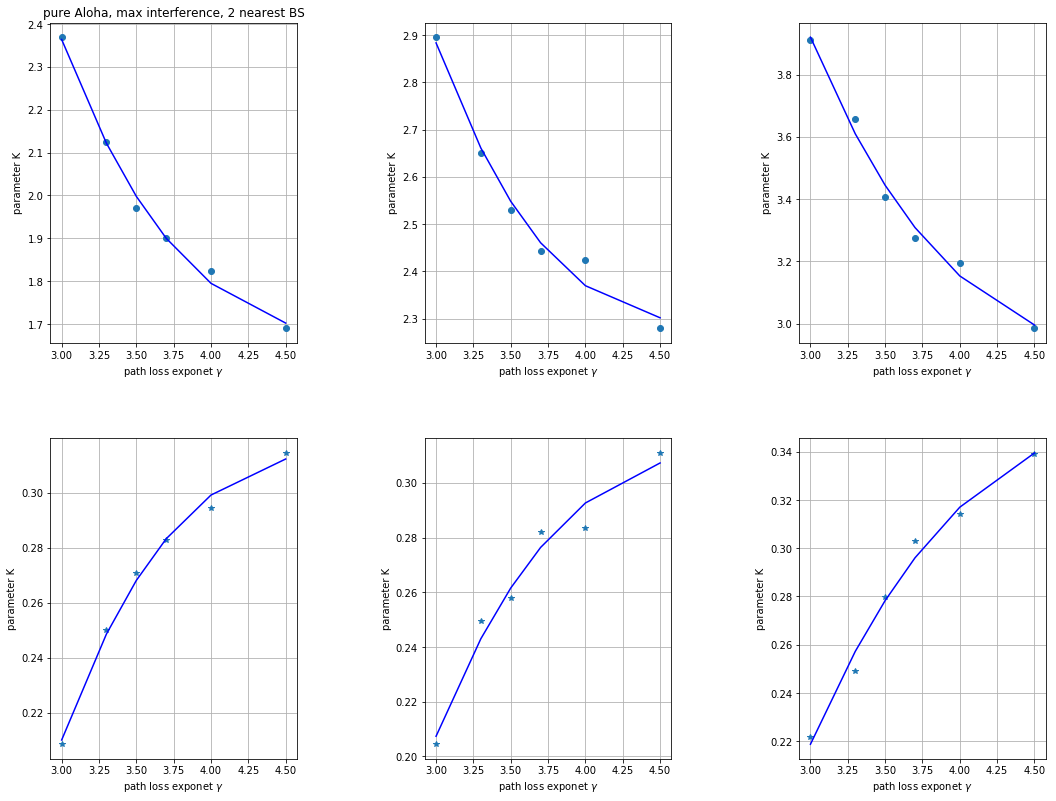

In [83]:
# fig3 = plt.plot()
# plt.plot(df['gamma'], predict_K, 'b')
# plt.plot(df['gamma'],df['K_pure_mean'], 'o')
axes2[0,0].plot(df['gamma'],f0(df['gamma']), 'b')
axes2[0,1].plot(df['gamma'],f1(df['gamma']), 'b')
axes2[0,2].plot(df['gamma'],f2(df['gamma']), 'b')

axes2[1,0].plot(df['gamma'],g0(df['gamma']), 'b')
axes2[1,1].plot(df['gamma'],g1(df['gamma']), 'b')
axes2[1,2].plot(df['gamma'],g2(df['gamma']), 'b')

fig2

In [149]:
X_END = 5.0
lambda_m = np.linspace(0, X_END, 190)
# 原则上我们让 基站的密度是个肯定值，毕竟这个东西投资大，没必要变化 lambda_b
lambda_b = 0.08
# gamma, path loss component. Usually take 4 as value.
p = 0.008
L = p*lambda_m/lambda_b

thetha_dB =3.0 
PKT_LOSS = np.array([0.1])
# print(L)

PURE = True
ITF_MEAN = True

if PURE == False:
    FIG_TITLE = 'S-ALOHA'
else:
    if ITF_MEAN == True:
        FIG_TITLE = 'Pa-Aloha' # Pure Aloha, mean
    else:
        FIG_TITLE = 'Pm-Aloha' # Pure Aloha, max
gammas = [3.3, 4.0, 4.5]

case:3.3
0.060    0.0180
0.080    0.0469
0.100    0.0853
0.125    0.1277
0.150    0.1902
0.175    0.2369
0.200    0.2790
0.250    0.3567
0.300    0.4253
0.350    0.4732
0.400    0.5278
0.500    0.5922
Name: 42, dtype: float64
[0.00359446 0.01255903 0.02894671 0.05886558 0.09603429 0.13690966
 0.17880929 0.25946706 0.33151154 0.39383846 0.44724656 0.53241794]
[0.15249548]
case:4.0
0.060    0.0119
0.080    0.0303
0.100    0.0507
0.125    0.0952
0.150    0.1355
0.175    0.1651
0.200    0.2158
0.250    0.2914
0.300    0.3374
0.350    0.4064
0.400    0.4436
0.500    0.5193
Name: 42, dtype: float64
[0.00416085 0.01162291 0.02418787 0.04671716 0.07516723 0.10741355
 0.14158846 0.21053541 0.27549043 0.33411563 0.38606191 0.47200109]
[0.16942772]
case:4.5
0.060    0.0084
0.080    0.0250
0.100    0.0444
0.125    0.0777
0.150    0.1156
0.175    0.1520
0.200    0.1837
0.250    0.2467
0.300    0.3165
0.350    0.3702
0.400    0.4126
0.500    0.4835
Name: 42, dtype: float64
[0.00427855 0.01120516 0.0

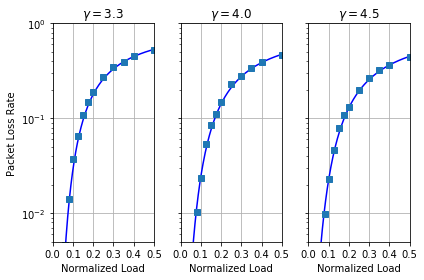

In [157]:
X_START = 0.0
X_END = 0.5
X_STEP = 0.002
Y_START = 5e-3
Y_END = 1.0
Y_STEP = 0.1
fig3, axes = plt.subplots(1, 3, sharey=True)


# Note that we only plot the case of pure Aloha with average interference
mrc_marker_styles = ['s', 'o', 'v', '+', 'd', 'D']
colors = ['r', 'b', 'k']
for i, gamma in enumerate(gammas):
    sim_log = os.path.join(SIM_LOG_DIR,"AlohaMultg" + str(int(gamma*10))+'s8t3b20.csv')
    df_log = pd.read_csv(sim_log, sep=";", decimal=',', index_col=0, skiprows=9, nrows=81).dropna(axis=1, how='all')
    df_log.columns = [float(x.replace(',', '.')) for x in df_log.columns.values]
    df_log_series = df_log.loc[43]
    

    print("case:{0}".format(gamma))
#     print(df_log_series)
    print(df_log.loc[42])
    print(curve_fitted_function(thetha_dB, loads, gamma, pure=PURE, itf_mean=ITF_MEAN))
    loads = df_log_series.index.values

    axes[i].set_yscale("log")
    axes[i].plot(L, curve_fitted_function(thetha_dB, L, gamma, pure=PURE, itf_mean=ITF_MEAN), 'b')
    axes[i].plot(loads, df_log_series, "s")
    axes[i].axis([X_START, X_END, Y_START, Y_END])
    axes[i].set_xlabel(r"Normalized Load")
    axes[i].set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    axes[i].set_title(r'$\gamma={0}$'.format(gamma))
    axes[i].plot()
    axes[i].grid()
    
    print("=========")
    print(inverse_curve_fitted_function(3.0, PKT_LOSS, gamma, pure=PURE, itf_mean=ITF_MEAN))
    
# plt.legend(loc='best')
axes[0].set_ylabel("Packet Loss Rate")

FIG_NAME = '{0}_{1}_and_sim_comp.pdf'.format(FIG_TITLE, "sim_fit")
plt.tight_layout()
plt.savefig(FIG_NAME, format='pdf', dpi=300)


Now we analyze the system capacity, which is defined as the normalized load leading to a packet loss rate $10\%$.
We have two approaches to obtain this:
- find the two points that cover the 
- from the predict model

Imaging we have two points $A_0=(a_0, b_0)$ and $A_1=(a_1, b_1)$. Point $(x, y)$ is the target we search that lies in the interval consituted by $A_0, A_1$. It is trivial to get the following equation.

$\frac{y-b_0}{x-a_0} = \frac{y-b_1}{x-a_1}$

After some basic mathmaticla operations, we get:

$x = \frac{a_0b_1-a_1b_0 + (a_1-a_0)y}{b_1-b_0}$

Let $y=0.1$. The above equation can be further simplifed as follows:

$x = \frac{a_0b_1-a_1b_0 + 0.1*(a_1-a_0)}{b_1-b_0}$

Recall that the packet loss in terms of normalized load is as follows:

$y = 1 - erf(\frac{1}{K\theta^{\frac{2}{\gamma}}x + B})$

By inversing the above equation, we can easily obtain:

$x =\frac{erfc^{-1}(y) - B}{K\theta^{\frac{2}{\gamma}}}$



In [73]:
# Case of SC, pure Aloha with average interfence (index=42), gamma =3.3
a_0, b_0 = 0.100,0.0853
a_1, b_1 = 0.125,0.1277
sys_cpty = (a_0*b_1-a_1*b_0 + (a_1-a_0)*0.1)/(b_1 - b_0)
# 0.114 is value calculated from analytical model
print(sys_cpty)
abs(sys_cpty - 0.114)/0.108


a_0, b_0 = 0.125,    0.0777
a_1, b_1 = 0.150,    0.1156
sys_cpty = (a_0*b_1-a_1*b_0 + (a_1-a_0)*0.1)/(b_1 - b_0)
# 0.114 is value calculated from analytical model
print(sys_cpty)
abs(0.163 - 0.15)/0.163

0.1086674528301887
0.13970976253298154


0.07975460122699393

In [135]:
def nothing(a_0, b_0, a_1, b_1, pkt_loss):
    return (a_0*b_1-a_1*b_0 + (a_1-a_0)*pkt_loss)/(b_1 - b_0)

In [140]:
a_0, b_0 =0.060,0.0024
a_1, b_1 =0.080,0.0099  
 
print(nothing(a_0, b_0, a_1, b_1, 0.005),(nothing(a_0, b_0, a_1, b_1, 0.005) - 0.0645)/nothing(a_0, b_0, a_1, b_1, 0.005))


0.06693333333333333 0.03635458167330671


In [146]:
a_0, b_0 = 0.060,    0.0031
a_1, b_1 = 0.080,   0.0103
 
print(nothing(a_0, b_0, a_1, b_1, 0.01))


0.07916666666666666


In [147]:
(0.0791-0.0766)/0.0791

0.03160556257901393

In [148]:
(0.0713-0.0757)/0.0713

-0.06171107994389903

In [161]:
a_0, b_0 = 0.100 ,    0.0853
a_1, b_1 = 0.125,    0.1277


   
    
a_2, b_2 = 0.125 ,    0.0952
a_3, b_3 =0.150,    0.1355

a_4, b_4 = 0.125,    0.0777
a_5, b_5 = 0.150,    0.1156

print(nothing(a_0, b_0, a_1, b_1, 0.1))

print(nothing(a_2, b_2, a_3, b_3, 0.1))
print(nothing(a_4, b_4, a_5, b_5, 0.1))

0.1086674528301887
0.12797766749379652
0.13970976253298154


In [154]:
(0.168-0.177)/0.168

-0.05357142857142845

In [156]:
(0.164-0.169)/0.164
(0.152-0.145)/0.145

0.048275862068965565